# <p style = "text-align: center;"><b>TWITTER SENTIMENT ANALYSIS</b></p>
<div style = "text-align: center;">
    <img style = "text-align: center;" src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcStMoNq6Jgs5_ysqMDEATmLm8HHcH7tJqo_zR3U4h7ZbQ&s">
</div>

## *Context*
 - The objective of this task is to detect sentiment from video game reviews left on Amazon.
 - Based on project found here:  https://github.com/koosha-t/Sentiment-Analysis-NLP-for-Marketting?tab=readme-ov-file


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='dark', color_codes=True, font_scale=1.5)

#NLP
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.stem.snowball import SnowballStemmer #You can call SnowballStemmer, but I believe everything we are working with is in English
from nltk.stem import WordNetLemmatizer #Lemmatizes words
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

#Annoying warnings begone!
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


## <p style = "text-align:center;"><b> 1. Downloading and creating the Amazon review dataset</b></p>

 - ### **NOTE:** This data is not in pure JSON and will need to be converted using ndjson
 - ### Creating two sample datasets: 
     - One with a balanced amount of reviews that's representative of reviews
     - One that is 100k completely random reviews


### **NOTE**: *Done in a separate notebook*

## <p style = "text-align:center;"><b> 2. Label each review with a sentiment score <i>(-1 to 1)</i> </b></p>


 - ### Loading up our sampled_data.csv 
 - ### Performing some NLP preprocessing with NLTK
    - *Going to need to use NLTK doco a lot here*
 - ### Labeling each review with a sentiment score

In [2]:
#Loading our sampled dataset
sampled_csv= pd.read_csv('/home/bglid/bglidden/learning_files/handsonML3/NLTK_Sentiment_Analysis/Datasets/sampled_data.csv')
sampled_reviews = pd.DataFrame(sampled_csv)
sampled_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   asin        4500 non-null   object 
 1   overall     4500 non-null   float64
 2   reviewText  4500 non-null   object 
 3   summary     4500 non-null   object 
dtypes: float64(1), object(3)
memory usage: 140.8+ KB


### NLTK Preprocessing
*We are not removing stopwords in this instance*

 - Tokenize
    - POS tagging
 - Stemming
 - Lemm
 - Label



In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
test_review = sampled_reviews['reviewText'][0]

[nltk_data] Downloading package punkt to /home/bglid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/bglid/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### **1. Tokenizing**

 - We want to use word_tokenize, because when we pass this to a stemmer, we want it to check each word.
     - *compared to sent_tokenize, which will pass each sentence to the stemmer*

In [4]:
#Do not need this function anymore

# #Tokenizer function
# def tokenizing_text(sentence):
#     tokenized_sent = sent_tokenize(sentence) 
#     # tokenized_words = [word_tokenize(word) for word in tokenized_sent] #wow I am stupid this is what I needed to remove
#     return tokenized_sent

In [5]:
example = sent_tokenize(test_review)
print(example)

['The graphics seem dated and rushed.', 'The gameplay was laborious and after 30 minutes I simply could not play anymore as it seemed I was wasting my time.', 'I was playing with two player option, but the second player wound up always having to be a robot.', "The second stage was having each character escape from the hospital and fight off robots and solve puzzles to open doors; I don't rememeber any of that in the movie.", 'I would not recommend.']


**We need to add POS tagging here:**

In [6]:
# tagged_example = pos_tag(example)
# print(tagged_example)

### **2. Stemming**

 - *Stemming using the Snowball Stemmer*

In [7]:
#Testing using our stemmer on our example sentence
stemmer = SnowballStemmer(language='english') #This performs better
# stemmer = PorterStemmer()
example_stemmed = [stemmer.stem(word) for word in example]
example_stemmed #Nice!!!

['the graphics seem dated and rushed.',
 'the gameplay was laborious and after 30 minutes i simply could not play anymore as it seemed i was wasting my time.',
 'i was playing with two player option, but the second player wound up always having to be a robot.',
 "the second stage was having each character escape from the hospital and fight off robots and solve puzzles to open doors; i don't rememeber any of that in the movie.",
 'i would not recommend.']

### **3. Lemmatizing**

    - Going to test this out using *WordNetLemmatizer*

    - Should we stemm and lemmatize/?? We might need to do some pos tagging

### WE ARE GOING TO SKIP THIS FOR NOW TO SKIP POS TAGGING

In [8]:
#We need wordnet
# nltk.download('wordnet')
#Building our Lemmatizer
wnl = WordNetLemmatizer()
example_lemmas = [wnl.lemmatize(word) for word in example_stemmed]
# example_lemmas #uh oh

### *Building our preprocessor into a Scikit-Learn Transformer*

 - We will use this to actually process the entire dataset

In [9]:
#Starting off creating a sklearn custom Transformer class to fit_transform our text
#Does not include sentiment analysis
class NLTKPreprocessing(BaseEstimator, TransformerMixin):
    #function to fit our data
    def fit(self, X, y=None):
        return self
    
    #Transforming function that returns our preprocessed text
    def transform(self, X, y=None):
        #Tokenizing each row in a Dataframe
        tokenized_text = []
        for doc in X:
            tokenized_text.append(sent_tokenize(doc))
            
        #Stemming the now tokenized lists of text
        stemmer = SnowballStemmer(language='english') 
        stemmed_tokens = []
        for review in tokenized_text:
            sentence = [] #List variable to hold each review
            for token in review:
                #Stemming each word in the review
                sentence.append(stemmer.stem(token))
            #Appending each stemmed review 
            stemmed_tokens.append(sentence)
            
        return stemmed_tokens

In [10]:
#Testing our transformer
text_preprocessor = NLTKPreprocessing()
tokenized_stemmed_doc = text_preprocessor.fit_transform(sampled_reviews['reviewText']) #did that actually work????

# sampled_reviews['stemmed tokens'] = tokenized_stemmed_doc # We don't actually need to join this column into the DF right now
# sampled_reviews #wow #NICE

### Sentiment Scoring using VADER

In [11]:
# nltk.download('vader_lexicon')

In [12]:
#Building out our sentiment scoring function:
def review_sentiment(review):
    #Init Sentiment Analysis 
    sid = SentimentIntensityAnalyzer() 
    review_sentiment = []
    #counter variables for getting the average score
    count = 0.0
    score = 0.0
    #Getting the sentiment of each sentence in the review
    for sentence in review:
        sentence_polarity = sid.polarity_scores(sentence)
        score += sentence_polarity['compound']
        count += 1
    #calculating the overall sentiment by way of the mean of each polarity score
    review_score = round((score / count), 4)
    return review_score

In [13]:
#Creating our Scikit-Learn Transformer for getting each review's sentiment:
class SentimentScorer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    #Transformer function that calculates each review's sentiment
    def transform(self, X, y = None):
        sentiment_scores = []
        for doc in X:
            #Getting the sentiment score for the review
            sentiment = review_sentiment(doc)
            sentiment_scores.append(sentiment)
        
        return sentiment_scores

In [14]:
# # #Test
# sample_stemmed_sent = tokenized_stemmed_doc[0:5].copy()
# print(sample_stemmed_sent)
# # print(f'\n Polarity score: {review_sentiment(sample_stemmed_sent)}') #Good for now

# #Testing our transformer
# scorer = SentimentScorer()
# scores = scorer.transform(sample_stemmed_sent)
# scores #WOW again lol

### Building out our Final Pipeline

In [15]:
#Building our final pipeline to take care of this entire process
final_pipeline = Pipeline([
    ('Text Preprocessing', NLTKPreprocessing()),
    ('Sentiment Scorer', SentimentScorer())
])
final_pipeline

Pipeline(steps=[('Text Preprocessing', NLTKPreprocessing()),
                ('Sentiment Scorer', SentimentScorer())])

In [16]:
#Scoring each review
review_scores = final_pipeline.fit_transform(sampled_reviews['reviewText'])

In [17]:
sampled_reviews['sentiment score'] = review_scores 
sampled_reviews

,asin,overall,reviewText,summary,sentiment score
0,B0007RDM5Q,1.0,The graphics seem dated and rushed. The gamep...,-,-0.1551
1,B007P6Y684,1.0,Cheap,One Star,0.0000
2,B00BQZ5EWW,1.0,background history\nI remember seeing ROME tot...,ROME II: BETA cause thats the quality they rel...,-0.0874
3,B0016BVY7U,1.0,Do not buy this game! The installation code in...,Game won't install because the included code d...,-0.2051
4,B0178FWY62,1.0,Its loud AF. Like one of the fans is hitting s...,Does not work as advertised.,0.1389
...,...,...,...,...,...
4495,B000VTQ3LU,5.0,"Great product, it worked as described and I ha...","Great product, it worked as described and I ha...",0.4939
4496,B00CMQTUSS,5.0,AMAZING price. Love it.,Thumbs Up,0.6114
4497,B00JK00S0S,5.0,Game is seriously one of the best games I have...,Six star game five an half star seller.,0.9628
4498,B0001KUE7S,5.0,This review is both for the X-BOX as well as t...,"Now get your lazy butt to Mars, Space Marine !",0.0916


## <p style = "text-align:center;"><b> 3. Evaluate the performance of our sentiment analyzer by comparing the sentiment scores with review ratings </b></p>

 - Display our scores and group them into Positive, Neutral, and Negative
 - Group the True ratings into positive, neugtral, and negative to compare the results


In [29]:
#function to group scores into positive, neutral, or negative
def score_classifier(sentiment_score, pos_threshold = 0.3, neg_threshold = -0.3): #Setting boundary thresholds to give flexibility when calling the function
    if sentiment_score > pos_threshold:
        return 'Positive'
    elif sentiment_score < neg_threshold:
        return 'Negative'
    else:
        return 'Neutral'

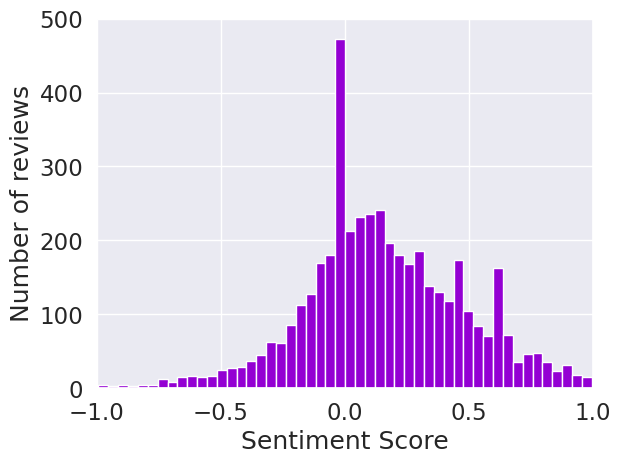

In [26]:
#Creating a histogram to display our current scores
plt.hist(sampled_reviews['sentiment score'], bins=50, color='darkviolet', label='Sentiment scores')
plt.grid()
plt.xlabel('Sentiment Score')
plt.ylabel('Number of reviews')
plt.axis([-1.0, 1.0, 0, 500])
plt.show()

In [32]:
categorized_scores = [score_classifier(score) for score in sampled_reviews['sentiment score']]
categorized_reviews = 

<Axes: ylabel='Count'>

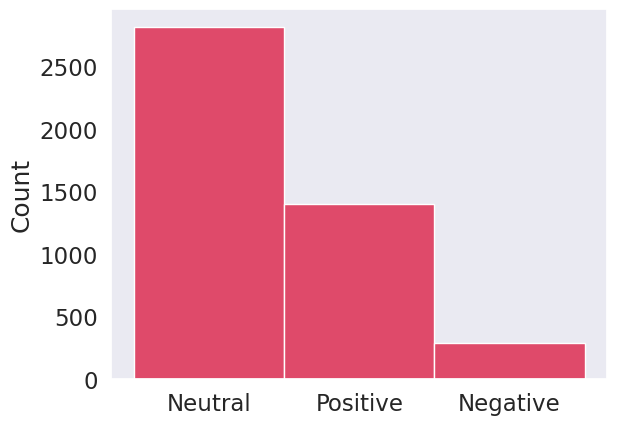

In [54]:
sns.histplot(categorized_scores, color='crimson')
# sns.histplot(sampled_reviews['sentiment score'])

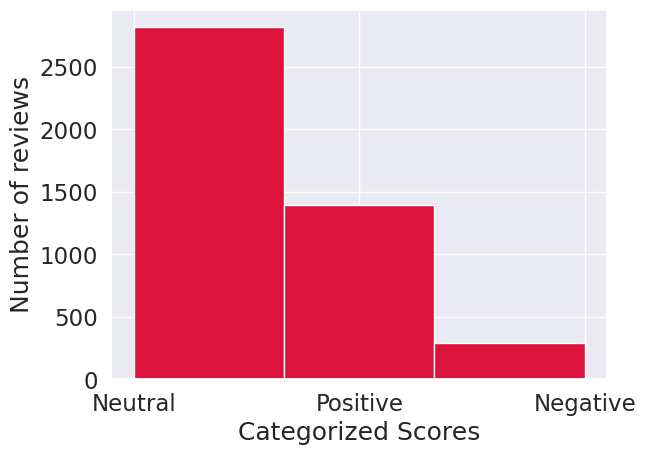

In [38]:
plt.hist(categorized_scores, bins = 3, color = 'crimson', label = 'categorized scores')
plt.grid()
plt.xlabel('Categorized Scores')
plt.ylabel('Number of reviews')
plt.show()

## <p style = "text-align:center;"><b> 4. Repeat the last two steps with deep learning models <i>BERT</i></b></p>


## <p style = "text-align:center;"><b> 5. Report and visualize the results</b></p>
